In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.models import resnet50
# from torchvision import transforms as T

In [2]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    """
    Convert bounding box format from [cx, cy, w, h] to [x1, y1, x2, y2]
    :param x: bounding boxes in [cx, cy, w, h] format, with values ranging from 0 to 1
    :return: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to 1
    """
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    """
    Convert bounding box scales (tensor) to image scales
    :param out_bbox: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to 1
    :param size: PIL image size
    :return: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to image dimension
    """
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)  # [x1, y1, x2, y2] format
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)  # rescale to image scales
    return b

In [3]:
def dert_plot_results(pil_img, results_, query=None):
    """
    Show image results
    :param pil_img: PIL image
    :param results_: inference results
    :param query: query string
    """
    # colors for visualization
    colors = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
              [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for res, color in zip(results_, colors * 100):
        label = res['label']
        score = res['score']
        box = res['box']
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color=color, linewidth=3))
        text = f'{label}: {score}'
        ax.text(box[0], box[1], text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
        
    if query is not None:
        # add title with query string
        plt.title(query, fontdict={'fontsize': 20})
        
    plt.axis('off')
    plt.show()

In [4]:
class DETRDetector(nn.Module):
    """
    DETR implementation with the following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine) 
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    Only batch size 1 supported.
    """
    def __init__(self, th=0.7, hidden_dim=256, n_heads=8, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        
        self.classes = [
            'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
            'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
            'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
            'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
            'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
            'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
            'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
            'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
            'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
            'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
            'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
            'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush'
        ]
        
        self.th = th

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(hidden_dim, n_heads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        self.linear_class = nn.Linear(hidden_dim, len(self.classes) + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs, img_size):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        height_, width_ = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:width_].unsqueeze(0).repeat(height_, 1, 1),
            self.row_embed[:height_].unsqueeze(1).repeat(1, width_, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        preds_logits = self.linear_class(h)
        probs = preds_logits.softmax(-1)[0, :, :-1]
        keep = probs.max(-1).values > self.th
        
        probs = probs[keep]
        boxes = self.linear_bbox(h).sigmoid()
        boxes = boxes[0, keep]
        
        bboxes = rescale_bboxes(boxes, img_size)
        
        results = []
        for prob, box in zip(probs, bboxes):
            results.append(
                {'label': self.classes[prob.argmax()], 'score': f'{prob[prob.argmax()]:0.2f}', 'box': box.tolist()}
            )
        return results

In [5]:
detr = DETRDetector(th=0.5)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cuda', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()

C:\Users\adnan\anaconda3\envs\DeepLearning-Project-venv\lib\site-packages\torch\nn\modules\transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


DETRDetector(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [6]:
from torchvision import transforms

In [7]:
image_path = r'\dataset\refcocog\images\COCO_train2014_000000374391.jpg'
im = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

img = transform(im).unsqueeze(0)
result = detr(img, im.size)

In [8]:
result

[{'label': 'teddy bear',
  'score': '1.00',
  'box': [12.576179504394531,
   113.6669692993164,
   295.7430725097656,
   362.44708251953125]},
 {'label': 'teddy bear',
  'score': '1.00',
  'box': [397.0268249511719,
   193.38743591308594,
   574.681884765625,
   400.70489501953125]},
 {'label': 'person',
  'score': '0.74',
  'box': [171.61846923828125,
   125.66008758544922,
   605.3941040039062,
   475.595458984375]},
 {'label': 'bottle',
  'score': '1.00',
  'box': [349.776611328125,
   302.44696044921875,
   440.05560302734375,
   416.7761535644531]},
 {'label': 'couch',
  'score': '0.97',
  'box': [0.4851341247558594,
   1.8895912170410156,
   639.9221801757812,
   474.0792541503906]},
 {'label': 'person',
  'score': '0.56',
  'box': [5.507946014404297,
   124.2280502319336,
   607.7344360351562,
   476.36029052734375]},
 {'label': 'bed',
  'score': '0.93',
  'box': [0.2721405029296875,
   1.5906000137329102,
   640.2481689453125,
   474.52410888671875]},
 {'label': 'person',
  'sc

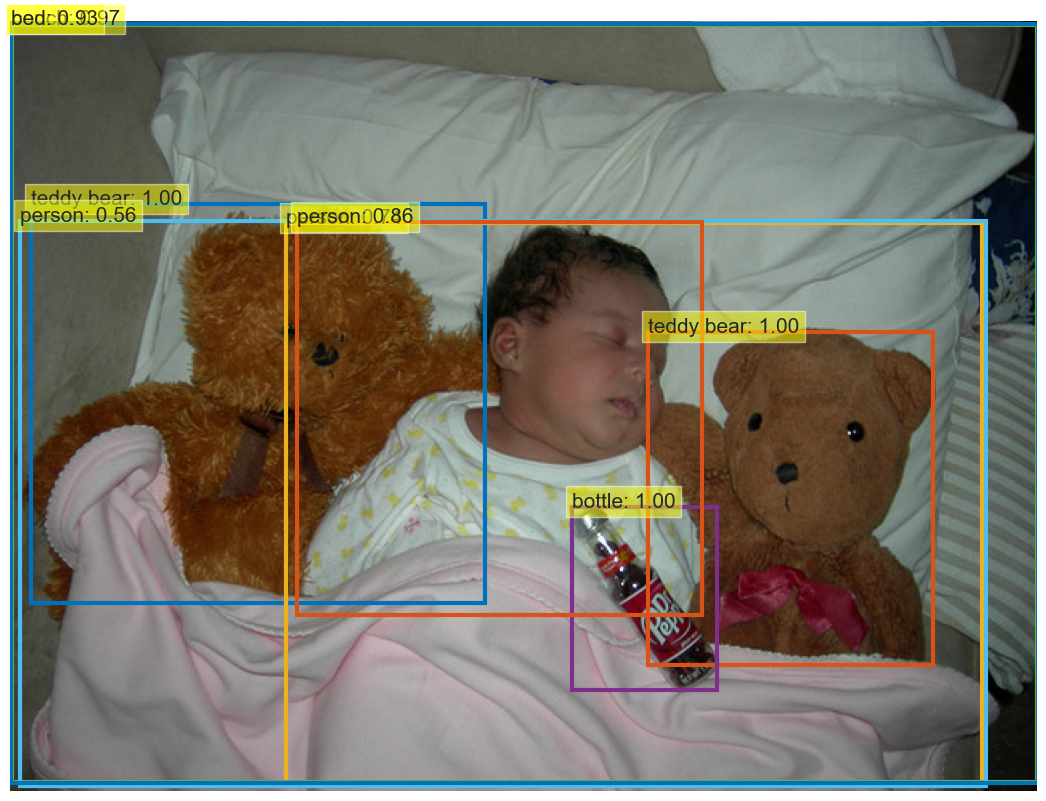

In [9]:
dert_plot_results(im, result)